In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [14]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        super(FS, self).__init__()
        self.num_params = num_params
        self.indices = torch.arange(1, num_params + 1).float()

        if num_params == 4:
            h = torch.tensor([6.0247, 3.0090, 1.5470, 1.0945])
            d = torch.tensor([6.1718, 3.0962, 1.5492, 0.7664])
            T = torch.tensor([5.8070, 2.8584, 1.3577, 0.5687])
        elif num_params == 8:
            h = torch.tensor([3.6760, 2.8168, 2.3811, 1.3095, 0.8152, 0.3878, 0.1751, 2.4152])
            d = torch.tensor([3.6922, 2.9805, 2.4332, 1.3228, 0.8048, 0.3861, 0.1863, 0.1023])
            T = torch.tensor([8.2595, 3.5255, 2.5539, 1.7761, 0.9528, 0.5461, 0.3573, 0.2881])
        elif num_params == 12:
            h = torch.tensor([1.1299, 6.8735, 4.4682, 2.0329, 1.3388, 0.7357, 0.7149, 0.4261, 0.6461, 0.4154, 0.2179, 0.3444])
            d = torch.tensor([-0.2083,  7.0264,  4.6516,  2.1096,  1.3740,  0.7480,  0.6828,  0.3809, 0.4077,  0.2240,  0.1159,  0.0536])
            T = torch.tensor([-3.5203,  5.9076,  4.0212,  1.8142,  0.9658,  0.3212, -0.0740, -0.4722, -0.7314, -1.2238, -1.3265, -1.4648])
        elif num_params == 16:
            h = torch.tensor([0.5602, 0.3329, 1.2282, 1.4916, 1.0170, 1.0777, 0.9202, 1.2722, 2.8685, 1.3212, 0.8411, 0.3989, 0.1870, 0.0936, 0.0616, 1.1349])
            d = torch.tensor([0.3161,  0.2175, -0.2093,  1.6195,  1.0840,  1.1121,  0.9249,  1.2900, 2.8708,  1.3277,  0.8375,  0.3912,  0.1875,  0.0973,  0.0640,  0.0406])
            T = torch.tensor([0.0984, -0.0835, -3.5130,  0.6933,  0.1460,  0.0137,  0.9415,  0.2020, 1.2894, -0.2560, -0.7142, -1.1954, -1.3832, -1.4649, -1.4901, -1.5134])

        """
        if self.num_params == 4:
            self.h = 0.6408 * self.indices**2 - 4.8293 * self.indices + 10.186
            self.d = 0.5732 * self.indices**2 - 4.6423 * self.indices + 10.203
            self.T = 0.5399 * self.indices**2 - 4.4211 * self.indices + 9.6514
        elif self.num_params == 8:
            self.h = -1.378 * torch.log(self.indices) + 3.5742
            self.d = -1.92 * torch.log(self.indices) + 4.0338
            self.T = -3.663 * torch.log(self.indices) + 7.1379
        elif self.num_params == 12:
            self.h = 0.0289 * self.indices**2 - 0.7486 * self.indices + 4.9117
            self.d = 0.0078 * self.indices**2 - 0.4573 * self.indices + 4.0149
            self.T = -0.0495 * self.indices**2 + 0.3057 * self.indices + 1.0462
        elif self.num_params == 16:
            self.h = -0.018 * self.indices**2 + 0.2526 * self.indices + 0.3753
            self.d = -0.0284 * self.indices**2 + 0.3955 * self.indices + 0.0063
            self.T = -0.021 * self.indices**2 + 0.1795 * self.indices - 0.0105
        """

        # self.h = nn.Parameter(h + torch.normal(0, 0.1, size=h.size()))
        # self.d = nn.Parameter(d + torch.normal(0, 0.1, size=d.size()))
        # self.T = nn.Parameter(T + torch.normal(0, 0.1, size=T.size()))

        self.h = nn.Parameter(h)
        self.d = nn.Parameter(d)
        self.T = nn.Parameter(T)

        #self.h = nn.Parameter(self.h)
        #self.d = nn.Parameter(self.d)
        #self.T = nn.Parameter(self.T)

        #Define FS parameters (now as learnable parameters)
        #self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        #self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        #self.T = nn.Parameter(torch.randn(num_params))

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Swish

In [15]:
"""
import matplotlib.ticker as ticker

# Training setup
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)
y_train = swish(x_train)

# Training for different K values
K_values = [4, 8, 12, 16]
models = []
colors = ['blue', 'green', 'orange', 'purple']

for K in K_values:
    model = FS(K)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    epochs = 20000
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    
    models.append(model)
    print(f'Trained model with K={K}')

# Plotting
plt.figure(figsize=(5, 3))
y_true = swish(x_train).squeeze()
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='red')

# Plot predictions
with torch.no_grad():
    for i, model in enumerate(models):
        y_pred = model(x_train).squeeze()
        plt.plot(x_train.numpy(), y_pred.numpy(), label=f'TBPI K={K_values[i]}', linestyle='--', color=colors[i])

# Formatting ticks to integer values and setting interval
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))  # X-axis interval
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3))  # Y-axis interval
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}'))

# Adjust tick label size
plt.tick_params(axis='both', which='major', labelsize=13)  # Increase tick label size

# Set labels and legend
# plt.xlabel('x')
# plt.ylabel('y')
plt.legend(fontsize='large')  # Increase legend font size

# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display and save the plot
plt.savefig('allgraph.pdf', format='pdf')  # Save as PDF
plt.show()

######################
# Plotting
plt.figure(figsize=(5, 3))
y_true = swish(x_train).squeeze()
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='red')

# Plot predictions
with torch.no_grad():
    for i, model in enumerate(models):
        y_pred = model(x_train).squeeze()
        plt.plot(x_train.numpy(), y_pred.numpy(), label=f'TBPI K={K_values[i]}', linestyle='--', color=colors[i])

# Set labels and legend
plt.xlim(3.5, 4.5)
plt.ylim(3.5, 4.5)

# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide x and y tick labels
ax.xaxis.set_tick_params(labelbottom=False)  # Hide x-axis labels
ax.yaxis.set_tick_params(labelleft=False)    # Hide y-axis labels
ax.set_xticks([]); ax.set_yticks([])  # Hide all ticks on x and y axes


# Display and save the plot
plt.savefig('allgraph_big1.pdf', format='pdf')  # Save as PDF
plt.show()

######################
# Plotting
plt.figure(figsize=(5, 3))
y_true = swish(x_train).squeeze()
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='red')

# Plot predictions
with torch.no_grad():
    for i, model in enumerate(models):
        y_pred = model(x_train).squeeze()
        plt.plot(x_train.numpy(), y_pred.numpy(), label=f'TBPI K={K_values[i]}', linestyle='--', color=colors[i])

# Set labels and legend
plt.xlim(3.3, 4.7)
plt.ylim(3.3, 4.7)

# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide x and y tick labels
ax.xaxis.set_tick_params(labelbottom=False)  # Hide x-axis labels
ax.yaxis.set_tick_params(labelleft=False)    # Hide y-axis labels
ax.set_xticks([]); ax.set_yticks([])  # Hide all ticks on x and y axes


# Display and save the plot
plt.savefig('allgraph_big.pdf', format='pdf')  # Save as PDF
plt.show()
"""

"\nimport matplotlib.ticker as ticker\n\n# Training setup\nx_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)\ny_train = swish(x_train)\n\n# Training for different K values\nK_values = [4, 8, 12, 16]\nmodels = []\ncolors = ['blue', 'green', 'orange', 'purple']\n\nfor K in K_values:\n    model = FS(K)\n    criterion = nn.MSELoss()\n    optimizer = optim.Adam(model.parameters(), lr=0.01)\n    epochs = 20000\n    \n    for epoch in range(epochs):\n        optimizer.zero_grad()\n        y_pred = model(x_train)\n        loss = criterion(y_pred, y_train)\n        loss.backward()\n        optimizer.step()\n\n        if epoch % 1000 == 0:\n            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')\n    \n    models.append(model)\n    print(f'Trained model with K={K}')\n\n# Plotting\nplt.figure(figsize=(5, 3))\ny_true = swish(x_train).squeeze()\nplt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='red')\n\n# Plot predictions\nwith torch.no_grad():\n    for i, mode

In [16]:
"""
#Plotting
plt.figure(figsize=(6, 4))
y_true = swish(x_train).squeeze()
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='red')

# Plot predictions
with torch.no_grad():
    for i, model in enumerate(models):
        y_pred = model(x_train).squeeze()
        plt.plot(x_train.numpy(), y_pred.numpy(), label=f'K={K_values[i]}', linestyle='--', color=colors[i])

# Formatting ticks to integer values and setting interval
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))  # X-axis interval
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3))  # Y-axis interval
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}'))

# Adjust tick label size
plt.tick_params(axis='both', which='major', labelsize=13)  # Increase tick label size

# Set labels and legend
# plt.xlabel('x')
# plt.ylabel('y')
plt.legend(fontsize='large')  # Increase legend font size

# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display and save the plot
plt.savefig('allgraph.pdf', format='pdf')  # Save as PDF
plt.show()

######################
# Plotting
plt.figure(figsize=(6, 4))
y_true = swish(x_train).squeeze()
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='red')

# Plot predictions
with torch.no_grad():
    for i, model in enumerate(models):
        y_pred = model(x_train).squeeze()
        plt.plot(x_train.numpy(), y_pred.numpy(), label=f'K={K_values[i]}', linestyle='--', color=colors[i])

# Set labels and legend
plt.xlim(3.5, 4.5)
plt.ylim(3.5, 4.5)

# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide x and y tick labels
ax.xaxis.set_tick_params(labelbottom=False)  # Hide x-axis labels
ax.yaxis.set_tick_params(labelleft=False)    # Hide y-axis labels
ax.set_xticks([]); ax.set_yticks([])  # Hide all ticks on x and y axes

# Display and save the plot
plt.savefig('allgraph_big1.pdf', format='pdf')  # Save as PDF
plt.show()

######################
# Plotting
plt.figure(figsize=(6, 4))
y_true = swish(x_train).squeeze()
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='red', linewidth=3)

# Plot predictions
with torch.no_grad():
    for i, model in enumerate(models):
        y_pred = model(x_train).squeeze()
        plt.plot(x_train.numpy(), y_pred.numpy(), label=f'K={K_values[i]}', linestyle='--', color=colors[i], linewidth=3)

# Set labels and legend
plt.xlim(3.3, 4.7)
plt.ylim(3.3, 4.7)

# Removing top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide x and y tick labels
ax.xaxis.set_tick_params(labelbottom=False)  # Hide x-axis labels
ax.yaxis.set_tick_params(labelleft=False)    # Hide y-axis labels
ax.set_xticks([]); ax.set_yticks([])  # Hide all ticks on x and y axes


# Display and save the plot
plt.savefig('allgraph_big.pdf', format='pdf')  # Save as PDF
plt.show()
"""

"\n#Plotting\nplt.figure(figsize=(6, 4))\ny_true = swish(x_train).squeeze()\nplt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='red')\n\n# Plot predictions\nwith torch.no_grad():\n    for i, model in enumerate(models):\n        y_pred = model(x_train).squeeze()\n        plt.plot(x_train.numpy(), y_pred.numpy(), label=f'K={K_values[i]}', linestyle='--', color=colors[i])\n\n# Formatting ticks to integer values and setting interval\nplt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))  # X-axis interval\nplt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3))  # Y-axis interval\nplt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))\nplt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}'))\n\n# Adjust tick label size\nplt.tick_params(axis='both', which='major', labelsize=13)  # Increase tick label size\n\n# Set labels and legend\n# plt.xlabel('x')\n# plt.ylabel('y')\nplt.legend(fontsize='large')  # Increase 

K=4

Epoch 1/20000, Loss: 0.03879478946328163
Epoch 1001/20000, Loss: 0.03879760205745697
Epoch 2001/20000, Loss: 0.03879609704017639
Epoch 3001/20000, Loss: 0.038796089589595795
Epoch 4001/20000, Loss: 0.038796521723270416
Epoch 5001/20000, Loss: 0.038794782012701035
Epoch 6001/20000, Loss: 0.038796599954366684
Epoch 7001/20000, Loss: 0.03879692405462265
Epoch 8001/20000, Loss: 0.0387948602437973
Epoch 9001/20000, Loss: 0.03879712149500847
Epoch 10001/20000, Loss: 0.03879716247320175
Epoch 11001/20000, Loss: 0.0387972816824913
Epoch 12001/20000, Loss: 0.03879517689347267
Epoch 13001/20000, Loss: 0.038795147091150284
Epoch 14001/20000, Loss: 0.038797300308942795
Epoch 15001/20000, Loss: 0.038796890527009964
Epoch 16001/20000, Loss: 0.03879551216959953
Epoch 17001/20000, Loss: 0.03879416361451149
Epoch 18001/20000, Loss: 0.03879699856042862
Epoch 19001/20000, Loss: 0.038796912878751755
Loss values: [0.03879478946328163, 0.03879673406481743, 0.038797520101070404, 0.03879641368985176, 0.038796

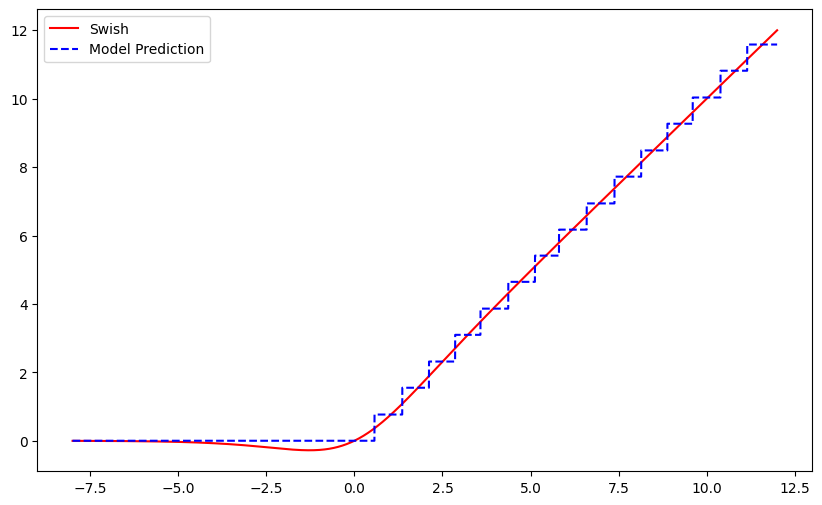

In [17]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Swish', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

Epoch 1/20000, Loss: 0.008968070149421692
Epoch 1001/20000, Loss: 0.008968143723905087
Epoch 2001/20000, Loss: 0.008968668058514595
Epoch 3001/20000, Loss: 0.008968435227870941
Epoch 4001/20000, Loss: 0.008968640118837357
Epoch 5001/20000, Loss: 0.008968266658484936
Epoch 6001/20000, Loss: 0.00896871741861105
Epoch 7001/20000, Loss: 0.008968226611614227
Epoch 8001/20000, Loss: 0.008968851529061794
Epoch 9001/20000, Loss: 0.008968336507678032
Epoch 10001/20000, Loss: 0.008968464098870754
Epoch 11001/20000, Loss: 0.008968673646450043
Epoch 12001/20000, Loss: 0.008968786336481571
Epoch 13001/20000, Loss: 0.008968573063611984
Epoch 14001/20000, Loss: 0.008968151174485683
Epoch 15001/20000, Loss: 0.008968464098870754
Epoch 16001/20000, Loss: 0.008968108333647251
Epoch 17001/20000, Loss: 0.008968287147581577
Epoch 18001/20000, Loss: 0.008968392387032509
Epoch 19001/20000, Loss: 0.008968548849225044
Loss values: [0.008968070149421692, 0.008968232199549675, 0.008968191221356392, 0.008968517184

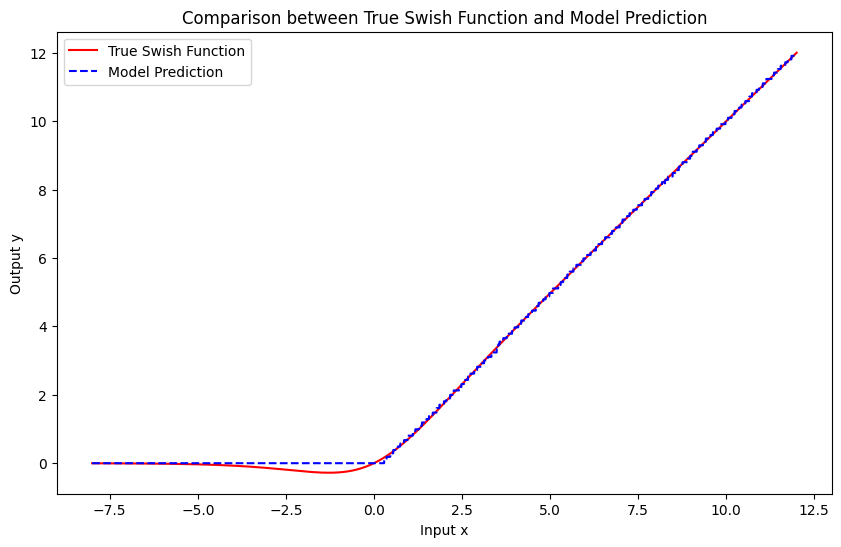

In [18]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=12

Epoch 1/20000, Loss: 0.0020457475911825895
Epoch 1001/20000, Loss: 0.001970399869605899
Epoch 2001/20000, Loss: 0.0017607483314350247
Epoch 3001/20000, Loss: 0.0015387983294203877
Epoch 4001/20000, Loss: 0.0015032290248200297
Epoch 5001/20000, Loss: 0.0014902761904522777
Epoch 6001/20000, Loss: 0.001487739966250956
Epoch 7001/20000, Loss: 0.0014899353263899684
Epoch 8001/20000, Loss: 0.001476244768127799
Epoch 9001/20000, Loss: 0.0014938331441953778
Epoch 10001/20000, Loss: 0.0015199121553450823
Epoch 11001/20000, Loss: 0.0015187935205176473
Epoch 12001/20000, Loss: 0.001518484321422875
Epoch 13001/20000, Loss: 0.0015206331154331565
Epoch 14001/20000, Loss: 0.0015208073891699314
Epoch 15001/20000, Loss: 0.0015208208933472633
Epoch 16001/20000, Loss: 0.001520565478131175
Epoch 17001/20000, Loss: 0.001520819845609367
Epoch 18001/20000, Loss: 0.0015209130942821503
Epoch 19001/20000, Loss: 0.00152077607344836
Loss values: [0.0020457475911825895, 0.002028549090027809, 0.0019922724459320307,

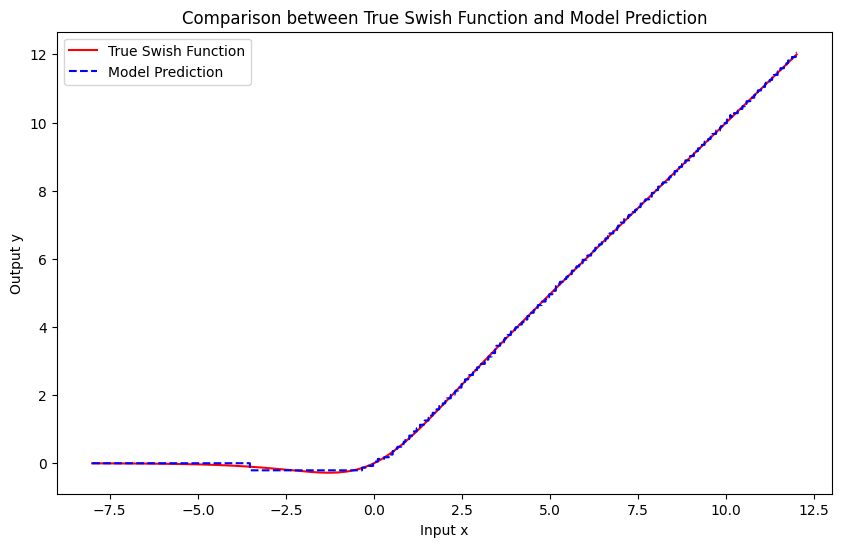

In [19]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.001041867770254612
Epoch 1001/20000, Loss: 0.0010426859371364117
Epoch 2001/20000, Loss: 0.0010449683759361506
Epoch 3001/20000, Loss: 0.0010437045712023973
Epoch 4001/20000, Loss: 0.0010466027306392789
Epoch 5001/20000, Loss: 0.0010431265691295266
Epoch 6001/20000, Loss: 0.0010460225166752934
Epoch 7001/20000, Loss: 0.0010475915623828769
Epoch 8001/20000, Loss: 0.0010406788205727935
Epoch 9001/20000, Loss: 0.0010409443639218807
Epoch 10001/20000, Loss: 0.0010372920660302043
Epoch 11001/20000, Loss: 0.0010362102184444666
Epoch 12001/20000, Loss: 0.001023610937409103
Epoch 13001/20000, Loss: 0.0010255412198603153
Epoch 14001/20000, Loss: 0.0010223191929981112
Epoch 15001/20000, Loss: 0.0010312279919162393
Epoch 16001/20000, Loss: 0.0010742547456175089
Epoch 17001/20000, Loss: 0.0010639607207849622
Epoch 18001/20000, Loss: 0.0010896784951910377
Epoch 19001/20000, Loss: 0.0013684016885235906
Loss values: [0.001041867770254612, 0.0010414363350719213, 0.00104185263626

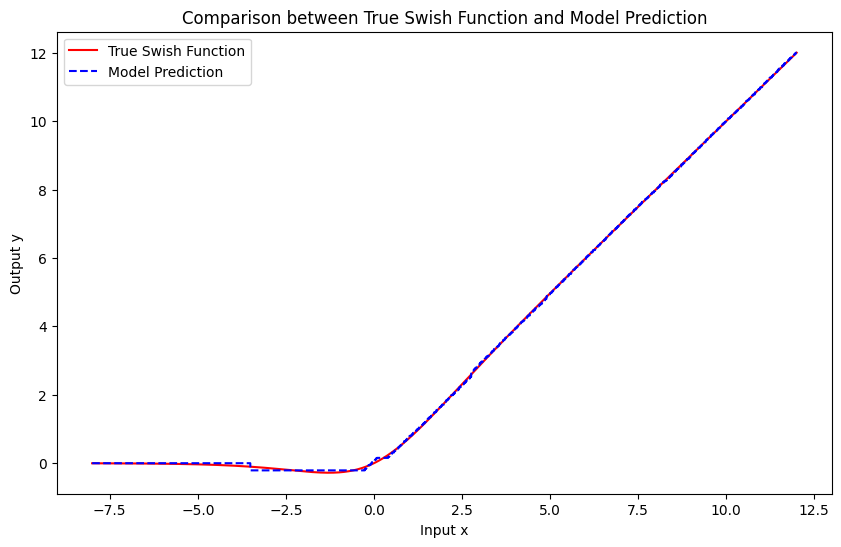

In [20]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()